In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Show first row of measurement table
firstRow_measurement = session.query(Measurement).first()
firstRow_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x29731e72320>,
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'tobs': 65.0}

In [10]:
# Show first row of station table
firstRow_station = session.query(Station).first()
firstRow_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x29731e72a90>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
engine.execute("SELECT MAX(date) FROM measurement").fetchall()

[('2017-08-23',)]

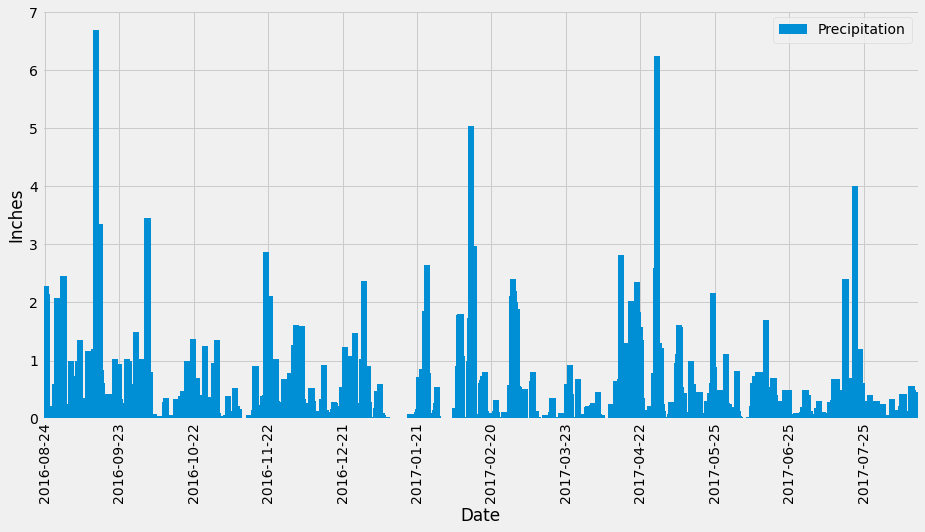

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mostRecent_str = engine.execute("SELECT MAX(date) FROM measurement").fetchall()[0][0]
mostRecent_dt = dt.datetime.strptime(mostRecent_str, "%Y-%m-%d")
# Calculate the date one year from the last date in data set.
yearAgo_dt = mostRecent_dt.replace(year=mostRecent_dt.year-1)
yearAgo_str = dt.datetime.strftime(yearAgo_dt, "%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
results = engine.execute(f"SELECT * FROM measurement WHERE date > '{yearAgo_str}';").fetchall()
# Save the query results as a Pandas DataFrame and set the index to the date column
measurements_df = pd.DataFrame(results, columns=['id', 'Station', 'Date', 'Precipitation', 'TOBS'])
# Set the index to the id from the database
measurements_df.set_index('id', inplace=True)

# Sort the dataframe by date(should already be)
measurements_df.sort_values('Date',inplace=True, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = measurements_df.plot.bar(x="Date", y="Precipitation", width=16, figsize=(14, 7))
ax.set_xticks(ax.get_xticks()[::190])
ax.set_xticklabels(measurements_df["Date"][::190])
plt.ylabel("Inches")
plt.savefig("Figures/precipitation_by_date")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurements_df.describe()

,Precipitation,TOBS
count,2015.000000,2223.000000
mean,0.176462,74.578947
std,0.460288,4.612232
min,0.000000,58.000000
25%,0.000000,71.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
#engine.execute("SELECT COUNT(DISTINCT station) FROM station").fetchall()
session.query(Station.station).count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    all()

station_counts.sort(reverse=True, key = lambda x: x[1])

for station, count in station_counts:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
largestStation = station_counts[0][0]

stationMax = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == f"{largestStation}").all()
print(f"The max recorded temp at station {largestStation} was {stationMax[0][1]} degrees Farenheit")

stationMin = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == f"{largestStation}").all()
print(f"The min recorded temp at station {largestStation} was {stationMin[0][1]} degrees Farenheit")

stationAvg = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == f"{largestStation}").all()
print(f"The average recorded temp at station {largestStation} was {stationAvg[0][1]} degrees Farenheit")

The max recorded temp at station USC00519281 was 85.0 degrees Farenheit
The min recorded temp at station USC00519281 was 54.0 degrees Farenheit
The average recorded temp at station USC00519281 was 71.66378066378067 degrees Farenheit


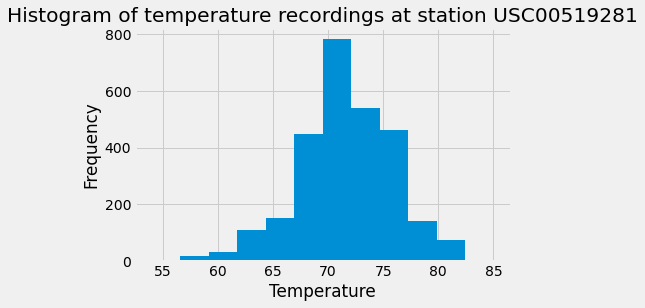

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.tobs).\
    filter(Measurement.station == f"{largestStation}")

tobs_df = pd.read_sql(query.statement, session.bind)

plt.hist(tobs_df["tobs"], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Histogram of temperature recordings at station {largestStation}")
plt.savefig("Figures/Largest_Station_Temp_Frequency")
plt.show()

# Close session

In [18]:
# Close Session
session.close()